In [ ]:
# default_exp backwards
# hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

# `Node2Vec` on MultiTree

In [ ]:
from directed_graphs.datasets import DirectedStochasticBlockModelHelper
from directed_graphs.datasets import visualize_heatmap
import torch

num_nodes = 35
num_clusters = 7

row = [0, 0, 1, 2, 2, 3, 4, 5]
col = [1, 2, 3, 3, 4, 5, 5, 6]
edge_index = torch.tensor([row, col])
data = DirectedStochasticBlockModelHelper(num_nodes=35, num_clusters=7, edge_index=edge_index, undir_prob=[0.8], dir_prob=[0.9])[0]

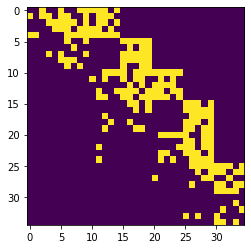

In [ ]:
visualize_heatmap(data.edge_index)

In [ ]:
# export datasets
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch
import networkx as nx

def visualize_edge_index(data, num_clusters=7):
  num_nodes = data.num_nodes
  nodes_per_cluster = num_nodes//num_clusters
  A = torch.sparse_coo_tensor(data.edge_index,torch.ones(data.edge_index.shape[1])).to_dense()
  row = []
  col = []
  for i in range(num_clusters):
    for j in range(i+1,num_clusters):
      ij_cnt = A[i*nodes_per_cluster:(i+1)*nodes_per_cluster,j*nodes_per_cluster:(j+1)*nodes_per_cluster].sum()
      ji_cnt = A[j*nodes_per_cluster:(j+1)*nodes_per_cluster,i*nodes_per_cluster:(i+1)*nodes_per_cluster].sum()
      if ij_cnt == 0 and ji_cnt == 0:
        continue
      if ij_cnt > ji_cnt:
        row.append(i)
        col.append(j)
      else:
        row.append(j)
        col.append(i)
  edge_index = torch.tensor([row, col])
  cluster_data = Data(x=torch.eye(num_clusters), edge_index=edge_index)
  G = to_networkx(cluster_data, to_undirected=False)
  nx.draw_networkx(G, pos=nx.planar_layout(G), arrowsize=20, node_color="#adade0")
  plt.show()

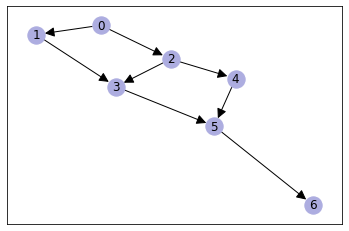

In [ ]:
from directed_graphs.datasets import visualize_edge_index
visualize_edge_index(data)

In [ ]:
import os
import torch

folder = "trees"
file = "multitree_7clusters_35nodes.pt"

if folder not in os.listdir():
  os.makedirs(folder)

torch.save(data, f"{folder}/{file}")

## Load presaved data

In [ ]:
import torch
data = torch.load("trees/multitree_7clusters_35nodes.pt")

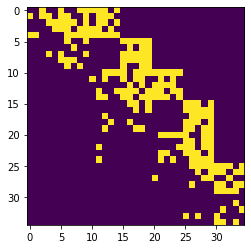

In [ ]:
from directed_graphs.datasets import visualize_heatmap
visualize_heatmap(data.edge_index)

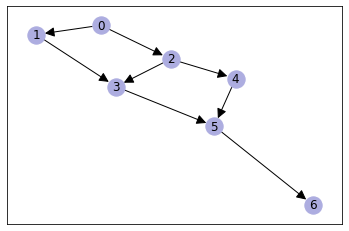

In [ ]:
from directed_graphs.datasets import visualize_edge_index
visualize_edge_index(data, num_clusters=7)

## Apply Backwards Node2Vec

In [ ]:
from directed_graphs.backwards import BackwardsNode2Vec
from torch_geometric.utils import to_networkx

G_nx = to_networkx(data, to_undirected=False)
node2vec2_model = BackwardsNode2Vec(G_nx, backward_discount=0.2, p=10, q=0.5, dimensions=3, walk_length=20, num_walks=5000, workers=4)
emb = node2vec2_model.get_embeddings(window=1)
emb.shape

Computing transition probabilities:   0%|          | 0/35 [00:00<?, ?it/s]

backward_discount = 0.2, dimension = 3, walk_length = 20, num_walks = 5000, window = 1


(35, 3)

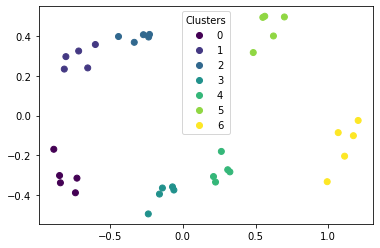

In [ ]:
from directed_graphs.datasets import plot_embeddings
plot_embeddings(emb, num_nodes=data.num_nodes, num_clusters=7)